In [1]:
pip install opencv-python numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
pip install torch --upgrade

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Encoder has 6 parameters.
Decoder has 6 parameters.
Epoch [1/10], Loss: 0.0128
Epoch [2/10], Loss: 0.0051
Epoch [3/10], Loss: 0.0049
Epoch [4/10], Loss: 0.0044
Epoch [5/10], Loss: 0.0041
Epoch [6/10], Loss: 0.0040
Epoch [7/10], Loss: 0.0038
Epoch [8/10], Loss: 0.0036
Epoch [9/10], Loss: 0.0036
Epoch [10/10], Loss: 0.0035
Models saved as encoder.pth and decoder.pth.


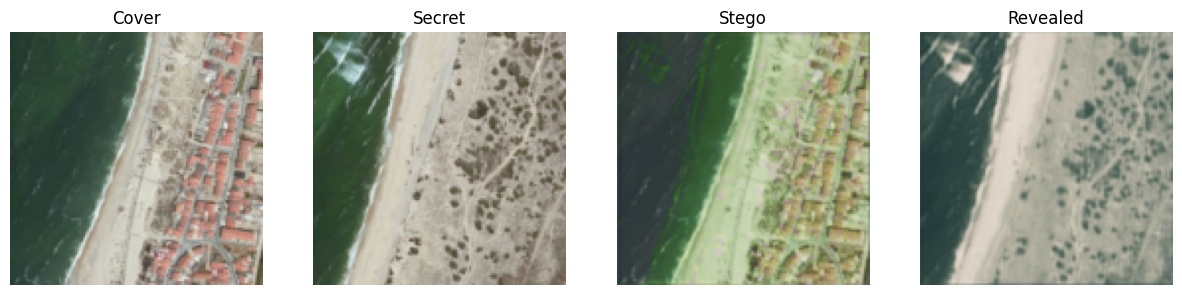

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# --------------------- Encoder & Decoder ---------------------
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(6, 64, 3, padding=1)  # 6 input channels (cover + secret)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)  # Output 3 channels (RGB)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, cover, secret):
        x = torch.cat([cover, secret], dim=1)  # Concatenate cover and secret images
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, 3, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, stego):
        x = self.relu(self.conv1(stego))
        x = self.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x

# --------------------- Dataset Loader ---------------------
class StegoDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)
                       if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        cover_path = self.images[idx]
        secret_path = random.choice(self.images)

        cover = Image.open(cover_path).convert("RGB")
        secret = Image.open(secret_path).convert("RGB")

        if self.transform:
            cover = self.transform(cover)
            secret = self.transform(secret)

        return cover, secret

# --------------------- Training Function ---------------------
def train(encoder, decoder, dataloader, device, epochs=10):
    criterion = nn.MSELoss()

    # Verify that the models have parameters
    encoder_params = list(encoder.parameters())
    decoder_params = list(decoder.parameters())

    print(f"Encoder has {len(encoder_params)} parameters.")
    print(f"Decoder has {len(decoder_params)} parameters.")
    
    # If no parameters exist in either model, we stop the training
    if len(encoder_params) == 0 or len(decoder_params) == 0:
        raise ValueError("Encoder or Decoder has no parameters!")

    optimizer = optim.Adam(encoder_params + decoder_params, lr=0.001)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for cover, secret in dataloader:
            cover = cover.to(device)
            secret = secret.to(device)

            stego = encoder(cover, secret)
            revealed = decoder(stego)

            loss_cover = criterion(stego, cover)
            loss_secret = criterion(revealed, secret)
            loss = loss_cover + loss_secret

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")

    torch.save(encoder.state_dict(), "encoder.pth")
    torch.save(decoder.state_dict(), "decoder.pth")
    print("Models saved as encoder.pth and decoder.pth.")

# --------------------- Utility Functions ---------------------
def load_image(path, transform):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)

def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img.permute(1, 2, 0).detach().cpu().numpy())
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

def test(encoder, decoder, transform, device, cover_path, secret_path):
    cover = load_image(cover_path, transform).to(device)
    secret = load_image(secret_path, transform).to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        stego = encoder(cover, secret)
        revealed = decoder(stego)

    show_images([cover[0], secret[0], stego[0], revealed[0]],
                ["Cover", "Secret", "Stego", "Revealed"])

# --------------------- Main ---------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # ====> Set paths properly here:
    train_folder = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images"           # Folder with multiple training images
    test_cover = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"          # Test cover image
    test_secret = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"        # Test secret image

    # Create dataset
    if not os.path.exists(train_folder):
        raise FileNotFoundError(f"Training folder not found: {train_folder}")
    dataset = StegoDataset(train_folder, transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Initialize models
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)

    # Train
    train(encoder, decoder, dataloader, device, epochs=10)

    # Reload for testing
    encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
    decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

    # Test
    test(encoder, decoder, transform, device, test_cover, test_secret)


# EVALUATION

In [2]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install skimage

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [3 lines of output]
      
      *** Please install the `scikit-image` package (instead of `skimage`) ***
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


In [3]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
import torchvision.transforms as transforms
from your_model_file import Encoder, Decoder  # replace with your actual model file name if needed

# --------------------- Load Image Utility ---------------------
def load_image(path, transform):
    image = Image.open(path).convert("RGB")
    return transform(image).unsqueeze(0)

# --------------------- Bit Error Rate (BER) ---------------------
def bit_error_rate(img1, img2):
    # Convert to numpy arrays, scale to 0-255, then to 8-bit integers
    arr1 = (img1 * 255).byte().cpu().numpy()
    arr2 = (img2 * 255).byte().cpu().numpy()

    total_bits = arr1.size * 8
    diff_bits = np.unpackbits(arr1 ^ arr2).sum()

    return diff_bits / total_bits

# --------------------- Main ---------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    # Load trained models
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    encoder.load_state_dict(torch.load("encoder.pth", map_location=device))
    decoder.load_state_dict(torch.load("decoder.pth", map_location=device))

    encoder.eval()
    decoder.eval()

    # Set test image paths
    cover_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"
    secret_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"

    # Load images
    cover = load_image(cover_path, transform).to(device)
    secret = load_image(secret_path, transform).to(device)

    with torch.no_grad():
        stego = encoder(cover, secret)
        revealed = decoder(stego)

    # Convert tensors to numpy images for metric calculations
    cover_np = cover.squeeze().permute(1, 2, 0).cpu().numpy()
    secret_np = secret.squeeze().permute(1, 2, 0).cpu().numpy()
    stego_np = stego.squeeze().permute(1, 2, 0).cpu().numpy()
    revealed_np = revealed.squeeze().permute(1, 2, 0).cpu().numpy()

    # --------------------- PSNR ---------------------
    psnr_cover_stego = psnr(cover_np, stego_np, data_range=1.0)
    psnr_secret_revealed = psnr(secret_np, revealed_np, data_range=1.0)

    # --------------------- SSIM ---------------------
    ssim_cover_stego = ssim(cover_np, stego_np, multichannel=True, data_range=1.0)
    ssim_secret_revealed = ssim(secret_np, revealed_np, multichannel=True, data_range=1.0)

    # --------------------- Entropy ---------------------
    entropy_stego = shannon_entropy(stego_np)
    entropy_revealed = shannon_entropy(revealed_np)

    # --------------------- BER ---------------------
    ber_secret_revealed = bit_error_rate(secret.squeeze(), revealed.squeeze())

    # --------------------- Print Results ---------------------
    print(f"PSNR (Cover vs Stego): {psnr_cover_stego:.2f} dB")
    print(f"PSNR (Secret vs Revealed): {psnr_secret_revealed:.2f} dB")

    print(f"SSIM (Cover vs Stego): {ssim_cover_stego:.4f}")
    print(f"SSIM (Secret vs Revealed): {ssim_secret_revealed:.4f}")

    print(f"Entropy (Stego Image): {entropy_stego:.4f}")
    print(f"Entropy (Revealed Secret): {entropy_revealed:.4f}")

    print(f"Bit Error Rate (Secret vs Revealed): {ber_secret_revealed:.6f}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch torchvision numpy scikit-image pillow matplotlib

Note: you may need to restart the kernel to use updated packages.


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [9]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
conda install numpy scikit-image --force-reinstall


Retrieving notices: ...working... done
Note: you may need to restart the kernel to use updated packages.

Channels:
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: d:\anaconda3

  added / updated specs:
    - numpy
    - scikit-image


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.2.25  |       haa95532_0         130 KB
    certifi-2025.4.26          |  py312haa95532_0         158 KB
    conda-24.11.3              |  py312haa95532_0         1.2 MB
    openssl-3.0.16             |       h3f729d1_0         7.8 MB
    pywavelets-1.8.0           |  py312h827c3e9_0         3.6 MB
    scikit-image-0.25.0        |  py312h5da7b33_0        10.7 MB
    ------------------------------------------------------------
                                           Total:        23.6 MB

The following packages will be UP

NameError: name 'transforms' is not defined

PSNR: 53.8694
SSIM: 0.9989
Cover Entropy: 7.1967
Stego Entropy: 7.1967
Revealed Entropy: 7.1974
BER (Cover vs Revealed): 0.9857


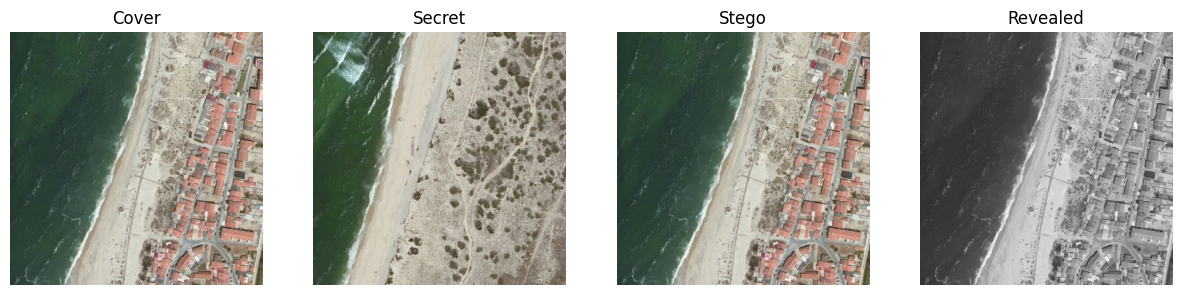

In [9]:
import numpy as np
import torch
import cv2
from skimage.metrics import structural_similarity as ssim
from math import log10
import torch.nn.functional as F
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# Function to compute PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * log10(PIXEL_MAX / np.sqrt(mse))

# Function to compute SSIM
def compute_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min(), multichannel=True)

# Function to compute entropy
def entropy(img):
    hist, _ = np.histogram(img.flatten(), bins=256, range=[0, 256])
    hist = hist / hist.sum()  # Normalize
    return -np.sum(hist * np.log2(hist + np.finfo(float).eps))

# Function to compute BER (Cover vs Revealed)
def compute_ber(secret, revealed):
    secret_flat = secret.flatten()
    revealed_flat = revealed.flatten()
    # Calculate bit error rate
    errors = np.sum(secret_flat != revealed_flat)
    total_bits = len(secret_flat)
    return errors / total_bits

# Function to perform DCT on image (as a placeholder for your steganography method)
def dct_transform(img):
    img_dct = cv2.dct(np.float32(img) - 128)  # DCT transform and shift to center around 0
    return img_dct

# Function to apply inverse DCT to get back the image
def inverse_dct(dct_img):
    img = cv2.idct(dct_img)
    return np.uint8(np.clip(img + 128, 0, 255))  # Clip to valid range [0, 255]

# Function to test the model with DCT-based transformations and metrics calculation
def test_dct_metrics(cover, secret, revealed):
    # Convert images to grayscale (if they are in RGB)
    cover_gray = cv2.cvtColor(cover, cv2.COLOR_BGR2GRAY)
    secret_gray = cv2.cvtColor(secret, cv2.COLOR_BGR2GRAY)
    revealed_gray = cv2.cvtColor(revealed, cv2.COLOR_BGR2GRAY)

    # Apply DCT on cover and stego
    cover_dct = dct_transform(cover_gray)
    stego_dct = dct_transform(revealed_gray)

    # Inverse DCT to reveal image (for testing purposes)
    recovered_img = inverse_dct(stego_dct)

    # Calculate PSNR
    psnr_value = psnr(cover_gray, recovered_img)

    # Calculate SSIM
    ssim_value = compute_ssim(cover_gray, recovered_img)

    # Calculate Entropy of Cover, Stego, and Revealed Images
    cover_entropy = entropy(cover_gray)
    stego_entropy = entropy(revealed_gray)
    revealed_entropy = entropy(recovered_img)

    # Calculate BER (Cover vs Revealed)
    ber_value = compute_ber(secret_gray, recovered_img)

    # Print metrics
    print(f"PSNR: {psnr_value:.4f}")
    print(f"SSIM: {ssim_value:.4f}")
    print(f"Cover Entropy: {cover_entropy:.4f}")
    print(f"Stego Entropy: {stego_entropy:.4f}")
    print(f"Revealed Entropy: {revealed_entropy:.4f}")
    print(f"BER (Cover vs Revealed): {ber_value:.4f}")

    # Plot images
    show_images([cover, secret, revealed, recovered_img], 
                ["Cover", "Secret", "Stego", "Revealed"])

# Function to show images
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load images (ensure these paths are correct)
    cover_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"
    secret_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"

    cover = cv2.imread(cover_path)
    secret = cv2.imread(secret_path)

    # For demonstration purposes, we assume the stego image is the same as the cover image here
    # In your case, the 'revealed' image will be the decoded result of your DCT-based encoding method
    revealed = cover.copy()  # Replace with actual stego image after decoding
    
    test_dct_metrics(cover, secret, revealed)


PSNR: 53.8694
SSIM: 0.9987
Cover Entropy: 7.1967
Stego Entropy: 7.1967
Revealed Entropy: 7.1974
BER (Secret vs Revealed): 0.9857


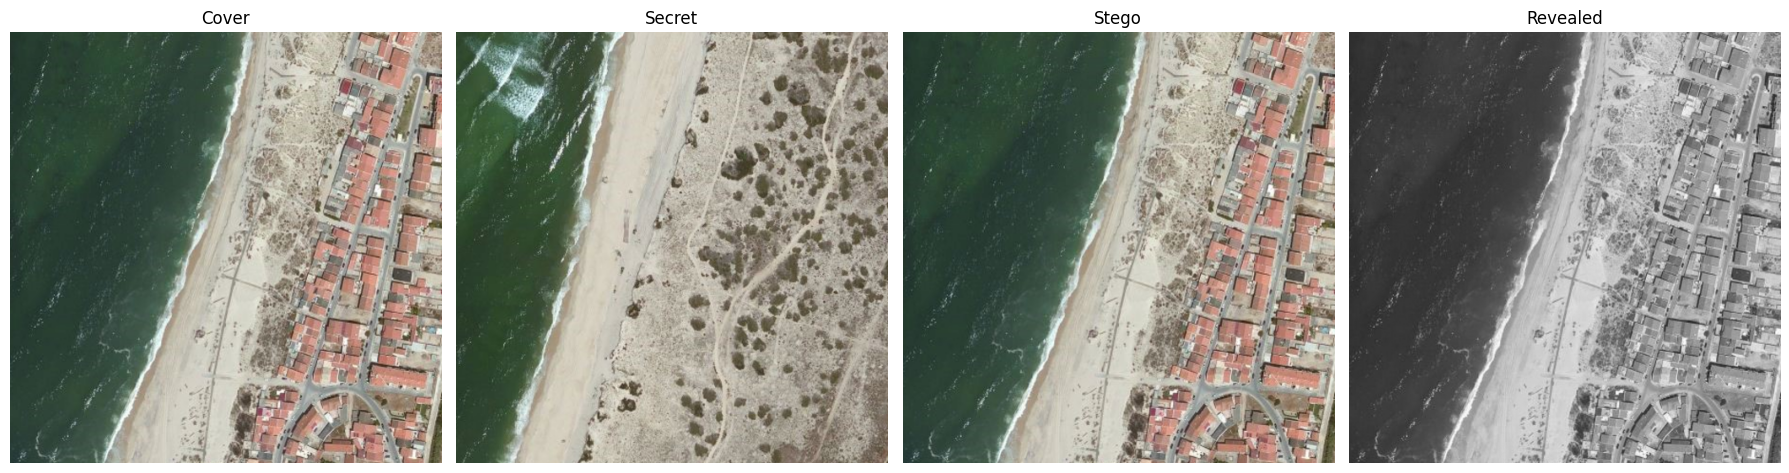

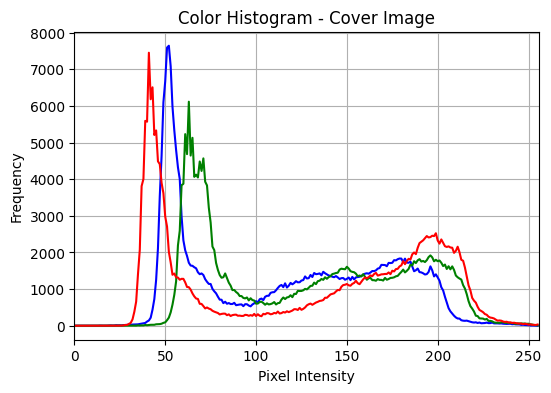

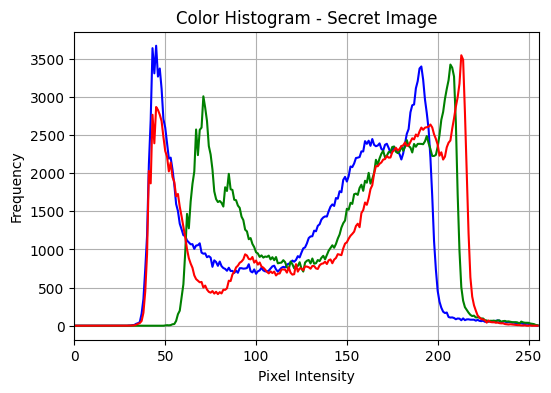

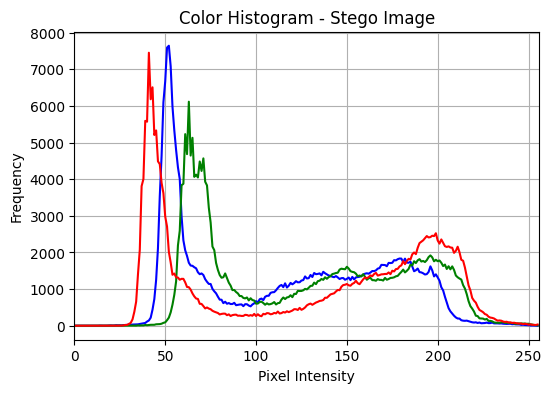

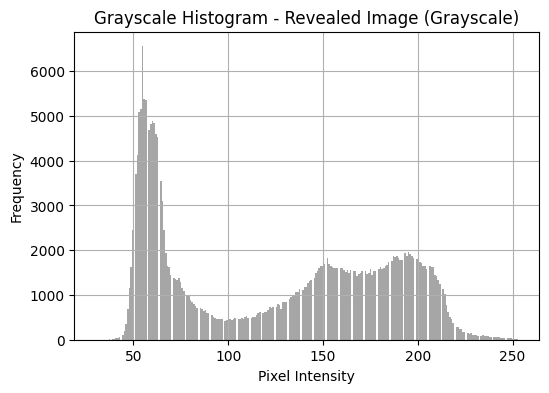

In [2]:
import numpy as np
import torch
import cv2
from skimage.metrics import structural_similarity as ssim
from math import log10
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# ======================== Metrics Functions ===========================

# PSNR
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * log10(PIXEL_MAX / np.sqrt(mse))

# SSIM
def compute_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min(), channel_axis=-1)

# Entropy
def entropy(img):
    hist, _ = np.histogram(img.flatten(), bins=256, range=[0, 256])
    hist = hist / hist.sum()
    return -np.sum(hist * np.log2(hist + np.finfo(float).eps))

# BER (bit error rate)
def compute_ber(secret, revealed):
    secret_flat = secret.flatten()
    revealed_flat = revealed.flatten()
    errors = np.sum(secret_flat != revealed_flat)
    total_bits = len(secret_flat)
    return errors / total_bits

# DCT and inverse DCT
def dct_transform(img):
    return cv2.dct(np.float32(img) - 128)

def inverse_dct(dct_img):
    img = cv2.idct(dct_img)
    return np.uint8(np.clip(img + 128, 0, 255))

# ======================== Visualization Functions ===========================

# RGB Histogram
def plot_color_histogram(img, title):
    colors = ('b', 'g', 'r')
    plt.figure(figsize=(6, 4))
    for i, col in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    plt.title(f'Color Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Grayscale Histogram
def plot_histogram(tensor_or_img, title):
    if isinstance(tensor_or_img, torch.Tensor):
        image = tensor_or_img.cpu().squeeze(0).numpy()  # shape: [C, H, W]
    else:
        image = tensor_or_img  # assuming numpy array
    plt.figure(figsize=(6, 4))
    plt.hist(image.flatten(), bins=256, color='gray', alpha=0.7)
    plt.title(f'Grayscale Histogram - {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Show images side by side
def show_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(18, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[i].set_title(title)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

# ======================== Main Test Function ===========================

def test_dct_metrics(cover, secret, revealed):
    # Convert images to grayscale for metrics and DCT
    cover_gray = cv2.cvtColor(cover, cv2.COLOR_BGR2GRAY)
    secret_gray = cv2.cvtColor(secret, cv2.COLOR_BGR2GRAY)
    revealed_gray = cv2.cvtColor(revealed, cv2.COLOR_BGR2GRAY)

    # Apply DCT and inverse DCT
    cover_dct = dct_transform(cover_gray)
    stego_dct = dct_transform(revealed_gray)
    recovered_img = inverse_dct(stego_dct)

    # Calculate Metrics
    psnr_value = psnr(cover_gray, recovered_img)
    ssim_value = compute_ssim(cover_gray, recovered_img)
    cover_entropy = entropy(cover_gray)
    stego_entropy = entropy(revealed_gray)
    revealed_entropy = entropy(recovered_img)
    ber_value = compute_ber(secret_gray, recovered_img)

    # Print results
    print(f"PSNR: {psnr_value:.4f}")
    print(f"SSIM: {ssim_value:.4f}")
    print(f"Cover Entropy: {cover_entropy:.4f}")
    print(f"Stego Entropy: {stego_entropy:.4f}")
    print(f"Revealed Entropy: {revealed_entropy:.4f}")
    print(f"BER (Secret vs Revealed): {ber_value:.4f}")

    # Show Images
    show_images([cover, secret, revealed, cv2.cvtColor(recovered_img, cv2.COLOR_GRAY2BGR)],
                ["Cover", "Secret", "Stego", "Revealed"])

    # RGB Histograms
    plot_color_histogram(cover, "Cover Image")
    plot_color_histogram(secret, "Secret Image")
    plot_color_histogram(revealed, "Stego Image")

    # Grayscale Histogram for Recovered Image
    plot_histogram(recovered_img, "Revealed Image (Grayscale)")

# ======================== Run Test ===========================

if __name__ == "__main__":
    cover_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_1.png"
    secret_path = r"C:\Users\dpriy\OneDrive\Desktop\ML_Project\images\Image_2.png"

    cover = cv2.imread(cover_path)
    secret = cv2.imread(secret_path)

    # For testing — assuming stego image same as cover (replace this with your actual stego result)
    revealed = cover.copy()

    test_dct_metrics(cover, secret, revealed)
